<a href="https://colab.research.google.com/github/Schimidel/Sisbahia/blob/main/An%C3%A1lise_Dados_Mare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Este notebook compara os dados de maré do modelo com os dados de maré de praticagem para o mês de março de 2024.

In [ ]:
#Importa o google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importa o pandas para ler a biblioteca
import pandas as pd

In [ ]:
#Lê a minha planilha do google sheets
url = 'https://docs.google.com/spreadsheets/d/1rskPNSp84J6bi194cn5T3Kg_osCpFUYCbXDZWoY5eeQ/export?format=csv&gid=1746989705' # Substitua 1234567890 pelo GID da sua segunda página
mare_praticagem = pd.read_csv(url)

url = 'https://docs.google.com/spreadsheets/d/1rskPNSp84J6bi194cn5T3Kg_osCpFUYCbXDZWoY5eeQ/export?format=csv&gid=0'
mare_modelo = pd.read_csv(url)

mare_modelo['Tempo'] = mare_modelo['Tempo']
mare_modelo['Elevação'] = mare_modelo['Elevação'] - mare_modelo['Elevação'].mean()
mare_praticagem['Maré real'] = mare_praticagem['Maré real'] - mare_praticagem['Maré real'].mean()

#Arruma a data e hora do arquivo
mare_praticagem['Data'] = mare_praticagem['Dia'] + ' ' + mare_praticagem['Hora']

#Transforma a data para um formato padrão
mare_praticagem['Data'] = pd.to_datetime(mare_praticagem['Data'], format='%d/%m/%Y %H:%M')

#Resampleia por hora os dados, para fazer a análise no sisbahia
mare_praticagem = mare_praticagem.resample('h', on='Data').mean(numeric_only=True)

#Interpola valores nulos
mare_praticagem = mare_praticagem.interpolate()

print(mare_modelo['Elevação'].mean())
print(mare_praticagem['Maré real'].mean())

import numpy as np

# Amplitude observada
amplitude_observada = np.max(mare_praticagem['Maré real']) - np.min(mare_praticagem['Maré real'])
print(amplitude_observada)

2.0749138941729077e-17
0.0022911967065191905
2.185


In [ ]:
# Amplitude observada e do modelo
amplitude_observada = 2.185
amplitude_modelo = np.max(mare_modelo['Elevação']) - np.min(mare_modelo['Elevação'])

# Fator de ajuste
fator_ajuste = amplitude_observada / amplitude_modelo

# Ajuste da série
#mare_modelo['Elevação']  = mare_modelo['Elevação'] * 1.03

print(amplitude_modelo)
print(fator_ajuste)

2.2181499999999996
0.9850551134954807


In [ ]:
# Converte a coluna tempo para datetime
mare_modelo['Tempo'] = pd.to_datetime(mare_modelo['Tempo'], unit='s', origin='2024-02-25')

# Set 'Tempo' como índice
mare_modelo = mare_modelo.set_index('Tempo')

# Resample para frequência horária
mare_modelo = mare_modelo.resample('h').mean()

mare_modelo = mare_modelo.loc[mare_modelo.index>'2024-03-01']

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mare_modelo.index,
    y=mare_modelo['Elevação'],
    mode='lines',
    name='Maré Modelo',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=mare_praticagem.index,
    y=mare_praticagem['Maré real'],
    mode='lines',
    name='Maré Práticagem',
    line=dict(color='red')
))

fig.update_layout(
    title='Comparação da Maré Modelo com a Maré Prática',
    xaxis_title='Data',
    yaxis_title='Nível da Maré',
    xaxis_tickangle=-45,
    legend=dict(x=0, y=1)
)

fig.show()

In [ ]:
mare_praticagem_filtrado = mare_praticagem.loc[mare_modelo.index]

#Calcula o RSME

# Selecionar a variável de interesse
var1 = mare_praticagem_filtrado['Maré real']
var2 = mare_modelo['Elevação']

# Calcular o RMSE
rmse = np.sqrt(np.mean((var1 - var2) ** 2))

print(f"O RMSE é: {rmse}")

O RMSE é: 0.07590648744843814


In [ ]:
# Cálculo do ICM
ICM = 100 * (1 - (np.sum(np.abs(var1 - var2)) / np.sum(np.abs(var1))))

# Resultados
print(f"ICM = {ICM:.2f}%")

ICM = 80.13%


In [ ]:
# Cálculo do ICE
ICE = 100 * (1 - np.abs(np.sum((var1**2) - (var2**2))) / np.sum(var1**2))

# Resultados
print(f"ICE = {ICE:.2f}%")

ICE = 99.22%


Equação da linha: y = 0.9828x + -0.0130
Coeficiente de correlação (R): 0.9813
Valor-p: 0.0000


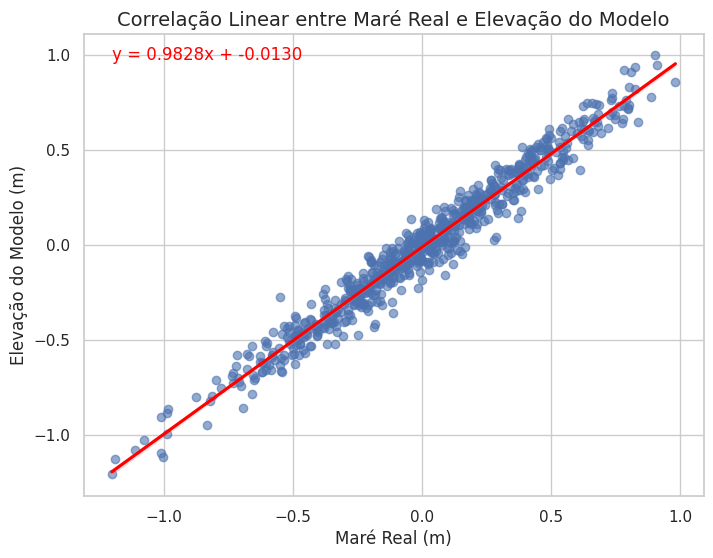

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Calcular os coeficientes da regressão linear
slope, intercept, r_value, p_value, std_err = linregress(var1, var2)

# Exibir a equação da linha de regressão
print(f"Equação da linha: y = {slope:.4f}x + {intercept:.4f}")
print(f"Coeficiente de correlação (R): {r_value:.4f}")
print(f"Valor-p: {p_value:.4f}")

# Criar o gráfico de dispersão com a linha de regressão
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(x=var1, y=var2, line_kws={"color": "red"}, scatter_kws={"alpha": 0.6})

# Adicionar a equação no gráfico
equation = f"y = {slope:.4f}x + {intercept:.4f}"
plt.text(x=min(var1), y=max(var2), s=equation, color="red", fontsize=12, ha="left", va="center")

# Personalizar o gráfico
plt.title("Correlação Linear entre Maré Real e Elevação do Modelo", fontsize=14)
plt.xlabel("Maré Real (m)", fontsize=12)
plt.ylabel("Elevação do Modelo (m)", fontsize=12)

# Exibir o gráfico
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Calcular o coeficiente de correlação
r, p_value = pearsonr(var1, var2)

print(f"Coeficiente de correlação (R): {r:.2f}")
print(f"Valor-p (P-value): {p_value:.4f}")

Coeficiente de correlação (R): 0.98
Valor-p (P-value): 0.0000
